# Libraries and Settings

### Libraries

In [1]:
##########==========##########==========##########==========##########==========
## import libraries
import numpy  as np 
import pandas as pd
import matplotlib.pyplot as plt


## import functions from libraries
from docx     import Document
from os       import listdir
from datetime import datetime
from fastkml  import KML, Placemark
from textwrap import TextWrapper
from cartopy  import feature


## import functions from library modules
from shapely.geometry  import MultiLineString, MultiPoint
from matplotlib.colors import hsv_to_rgb, to_hex
from cartopy.crs       import LambertConformal, PlateCarree
from cartopy.io        import shapereader
from sklearn.neighbors import KNeighborsRegressor


## define general purpose functions
def run_silently(func, arg):
    import sys, os
    so = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    result = func(arg)
    sys.stdout = so
    return result

def time_check(id = 'X'):
    now = datetime.now()
    h   = now.hour
    m   = now.minute
    s   = now.second
    now = 'Time Check ' + id + ': ' + str(h) + ':' + str(m) + ':' + str(s)
    print('\n', now, '\n')
    
time_check('[Start]')


 Time Check [Start]: 11:28:14 



### Settings

In [2]:
## set visual parameters
set_color = {
    'Foreground': (0/12, 0.00, 0.0),
    'Background': (7/12, 0.05, 1.0),
    'Divider':    (7/12, 1.00, 0.5),

    'Coast':      (7/12, 0.50, 0.7),
    'Border':     (1/12, 0.05, 0.8),
    'Land':       (1/12, 0.05, 1.0),

    'Photo':      (1/12, 0.80, 0.3),
    'Visit':      (1/12, 0.80, 0.6),
    'Unvisit':    (1/12, 0.20, 1.0)
}
for i in set_color.keys():
    set_color[i] = to_hex(hsv_to_rgb(set_color[i]))
set_color['Clear'] = '#00000000'

set_opp_color = [
    to_hex(hsv_to_rgb((6/12, 0.8, 0.5))) + '00',
    to_hex(hsv_to_rgb((6/12, 0.8, 0.5))) + '10',
    to_hex(hsv_to_rgb((6/12, 0.8, 0.5))) + '40',
    to_hex(hsv_to_rgb((6/12, 0.8, 0.5))) + '60',
    to_hex(hsv_to_rgb((6/12, 0.8, 0.5))) + '90',
    to_hex(hsv_to_rgb((6/12, 0.8, 0.5))) + 'A0'
    ]

set_fontsize = {'L':48, 'M':int(48 * 0.6), 'S':int(48 * 0.6**2)}

set_bbox = dict(
    fc = set_color['Background'] + '80',
    ec = set_color['Coast'] + '40',
    boxstyle = 'Round')

no_bbox = dict(
    fc = '#00000000',
    ec = '#00000000',
    boxstyle = 'Round')

set_text_wrap = {
    'intro':       63,
    'progress':    63 - 2,
    'opportunity': 25,
    'route':       25,
    'travel':      50
    }

## set tech parameters
set_core = {}

set_cache = {}

## set map parameters
set_map = {'all_opportunity': False,
    'extent': [-124.73 + 5, -66.95 - 5, 25.12 - 3.3, 49.38 + 3.3],
    'projection': LambertConformal(
        central_longitude = (-124.73 - 66.95) / 2,
        central_latitude = (25.12 + 49.38) / 2,
        standard_parallels = (25.12, 49.38)
        ),
    'panel': ['travel', 'route', 'opportunity']
    }

# Import Data

### Import Docx

In [3]:
## import a docx
def import_docx(address):
    txt = Document(address).paragraphs
    txt = [i.text for i in txt]
    txt = '\n'.join(txt)
    return txt

## import many docx in parallel
def import_all_docx(address):
    
    ## search for docx
    docx_roster = listdir(address)
    docx_roster = [i for i in docx_roster if i[-4:] == 'docx']
    
    ## import text from each docx
    docx_text = dict()
    for i in docx_roster:
        docx_text[i[:-5]] = import_docx(address + i)
        
    return(docx_text)

## execute functions
imported_docx = import_all_docx('A_Input/paragraph_text/')

### Import Xlsx

In [4]:
## import list of US cities to see
col_list = {'City':str, 'State':str, 'Route':str, 'Visit':int, 'Photo':int,
             'Score':int, 'lon':float, 'lat':float}
city_roster = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Cities',
    usecols = col_list.keys(), dtype = col_list)

## import list of travel routes
col_list = {'route':str, 'pre_travel':str, 'drive_mileage':int, 'trip_days':int,
               'best_temp_1':str, 'best_temp_2':str, 'states_etc':str}
route_roster = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Routes',
    usecols = col_list.keys(), dtype = col_list)

## optional: resets opportunity map to count all cities, regardless of visits
if set_map['all_opportunity']:
    city_roster['Score'] = 2
    city_roster['Visit'] = 0
    city_roster['Photo'] = 0

### Import Kml

In [5]:
## read in kml files
def import_kml(address):
    with open(address, 'rt', encoding = 'utf-8') as conn:
        raw_text = conn.read().encode('utf-8')
        parsed_kml = KML()
        parsed_kml.from_string(raw_text)
        conn.close()
    return parsed_kml

## process kml files
def process_kml(kml_object):
    
    ## extract route names
    get_name_attr = lambda a: a.name
    def extract_name(x):
        if len(list(x.features())) > 1:
            y = x.features()
            y = [get_name_attr(i) for i in y]
            return y
        else:
            return extract_name(list(x.features())[0])
    kml_name = extract_name(kml_object)
    
    ## extract route lines
    def extract_line(x):
        if isinstance(x, Placemark):
            return x.geometry
        else:
            return [extract_line(i) for i in x.features()]
    kml_line = extract_line(kml_object)
    
    ## extract line from superfluous nesting
    def unnest(x):
        if len(x) == 1:
            return unnest(x[0])
        else:
            return x
    kml_line = unnest(kml_line)
    
    ## merge lines that are part of the same route
    kml_line = [MultiLineString(i) for i in kml_line]
    
    ## package routes with names
    kml_line_dict = dict()
    for i in range(len(kml_name)):
        kml_line_dict[kml_name[i]] = kml_line[i]
        
    return kml_line_dict
    

## execute functions
route_kml  = import_kml('A_Input/Wishlist.kml')
route_kml  = process_kml(route_kml)

travel_kml = import_kml('A_Input/Travels.kml')
travel_kml = process_kml(travel_kml)

### read mexico masking shp layer

In [6]:
def read_shp(addr):
    shp = shapereader.Reader(addr).records()
    shp = next(shp).geometry
    return feature.ShapelyFeature(shp.geoms, PlateCarree())

mex_mask = read_shp('A_Input/gadm40_MEX_shp/gadm40_MEX_0.shp')

### calculate miles

In [7]:
## estimate the ratio between distance (miles) and Shapely's length units
def calibrate_distance_constant(kml = route_kml, roster = route_roster):
    roster['len'] = np.nan
    roster = roster.set_index('route')
    for i in kml.keys(): roster.loc[i, 'len'] = kml[i].length
    roster = roster.dropna()
    ratio = roster['drive_mileage'].values / roster['len'].values
    return np.median(ratio)

## estimate total drive mileage for traveled routes
def sum_miles_traveled(constant, kml = travel_kml):
    ## calculate distance
    miles_traveled = 0
    for i in kml.keys():
        miles_traveled += travel_kml[i].length * constant
    ## format for distance
    miles_traveled = str(int(np.round(miles_traveled, -2)))
    miles_traveled =  miles_traveled[0:-3] + ',' + miles_traveled[-3::]
    return miles_traveled
    
## execute code
miles_length_constant = calibrate_distance_constant()
miles_traveled = sum_miles_traveled(miles_length_constant)

### Enrich Data

In [8]:
## add additional columns to the route_roster
def enrich_route(route = route_roster, city = city_roster.copy()):
    
    ## round mileage to nearest 50 miles
    route['mileage'] = (np.round(route['drive_mileage'] / 50) * 50).astype(int)
    
    ## score each route for opportunities to advance towards goal
    route_score = city[['Route', 'Score']].groupby('Route').sum()
    route_score = route.join(route_score, on = 'route')['Score']
    route['score'] = route_score
    
    ## order routes into table order
    route = route[['route', 'mileage', 'trip_days', 'best_temp_1',
        'best_temp_2', 'score', 'pre_travel', 'states_etc', 'drive_mileage']]
    
    return route

## add state boolean to city_roster
def enrich_city(city = city_roster):
    city['IsState'] = ~city.State.isin(['PR', 'CAN', 'DC'])
    return city
    

## wrap text
def wrap_text(text_str, len_int):
    text_wrap = TextWrapper(width = len_int, break_long_words = False)
    return text_wrap.fill(text = text_str)

## execute
route_roster = enrich_route(route_roster)
city_roster = enrich_city(city_roster)
for i in set_text_wrap.keys():
    imported_docx[i] = wrap_text(imported_docx[i], set_text_wrap[i])
imported_docx['intro'] = imported_docx['intro'] + '\n' * 2

# Dashboard Architecture

### Style

In [9]:
## computations
def define_style():
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Quicksand']
    plt.rcParams['font.weight'] = 'medium'
    
define_style()

### Layout

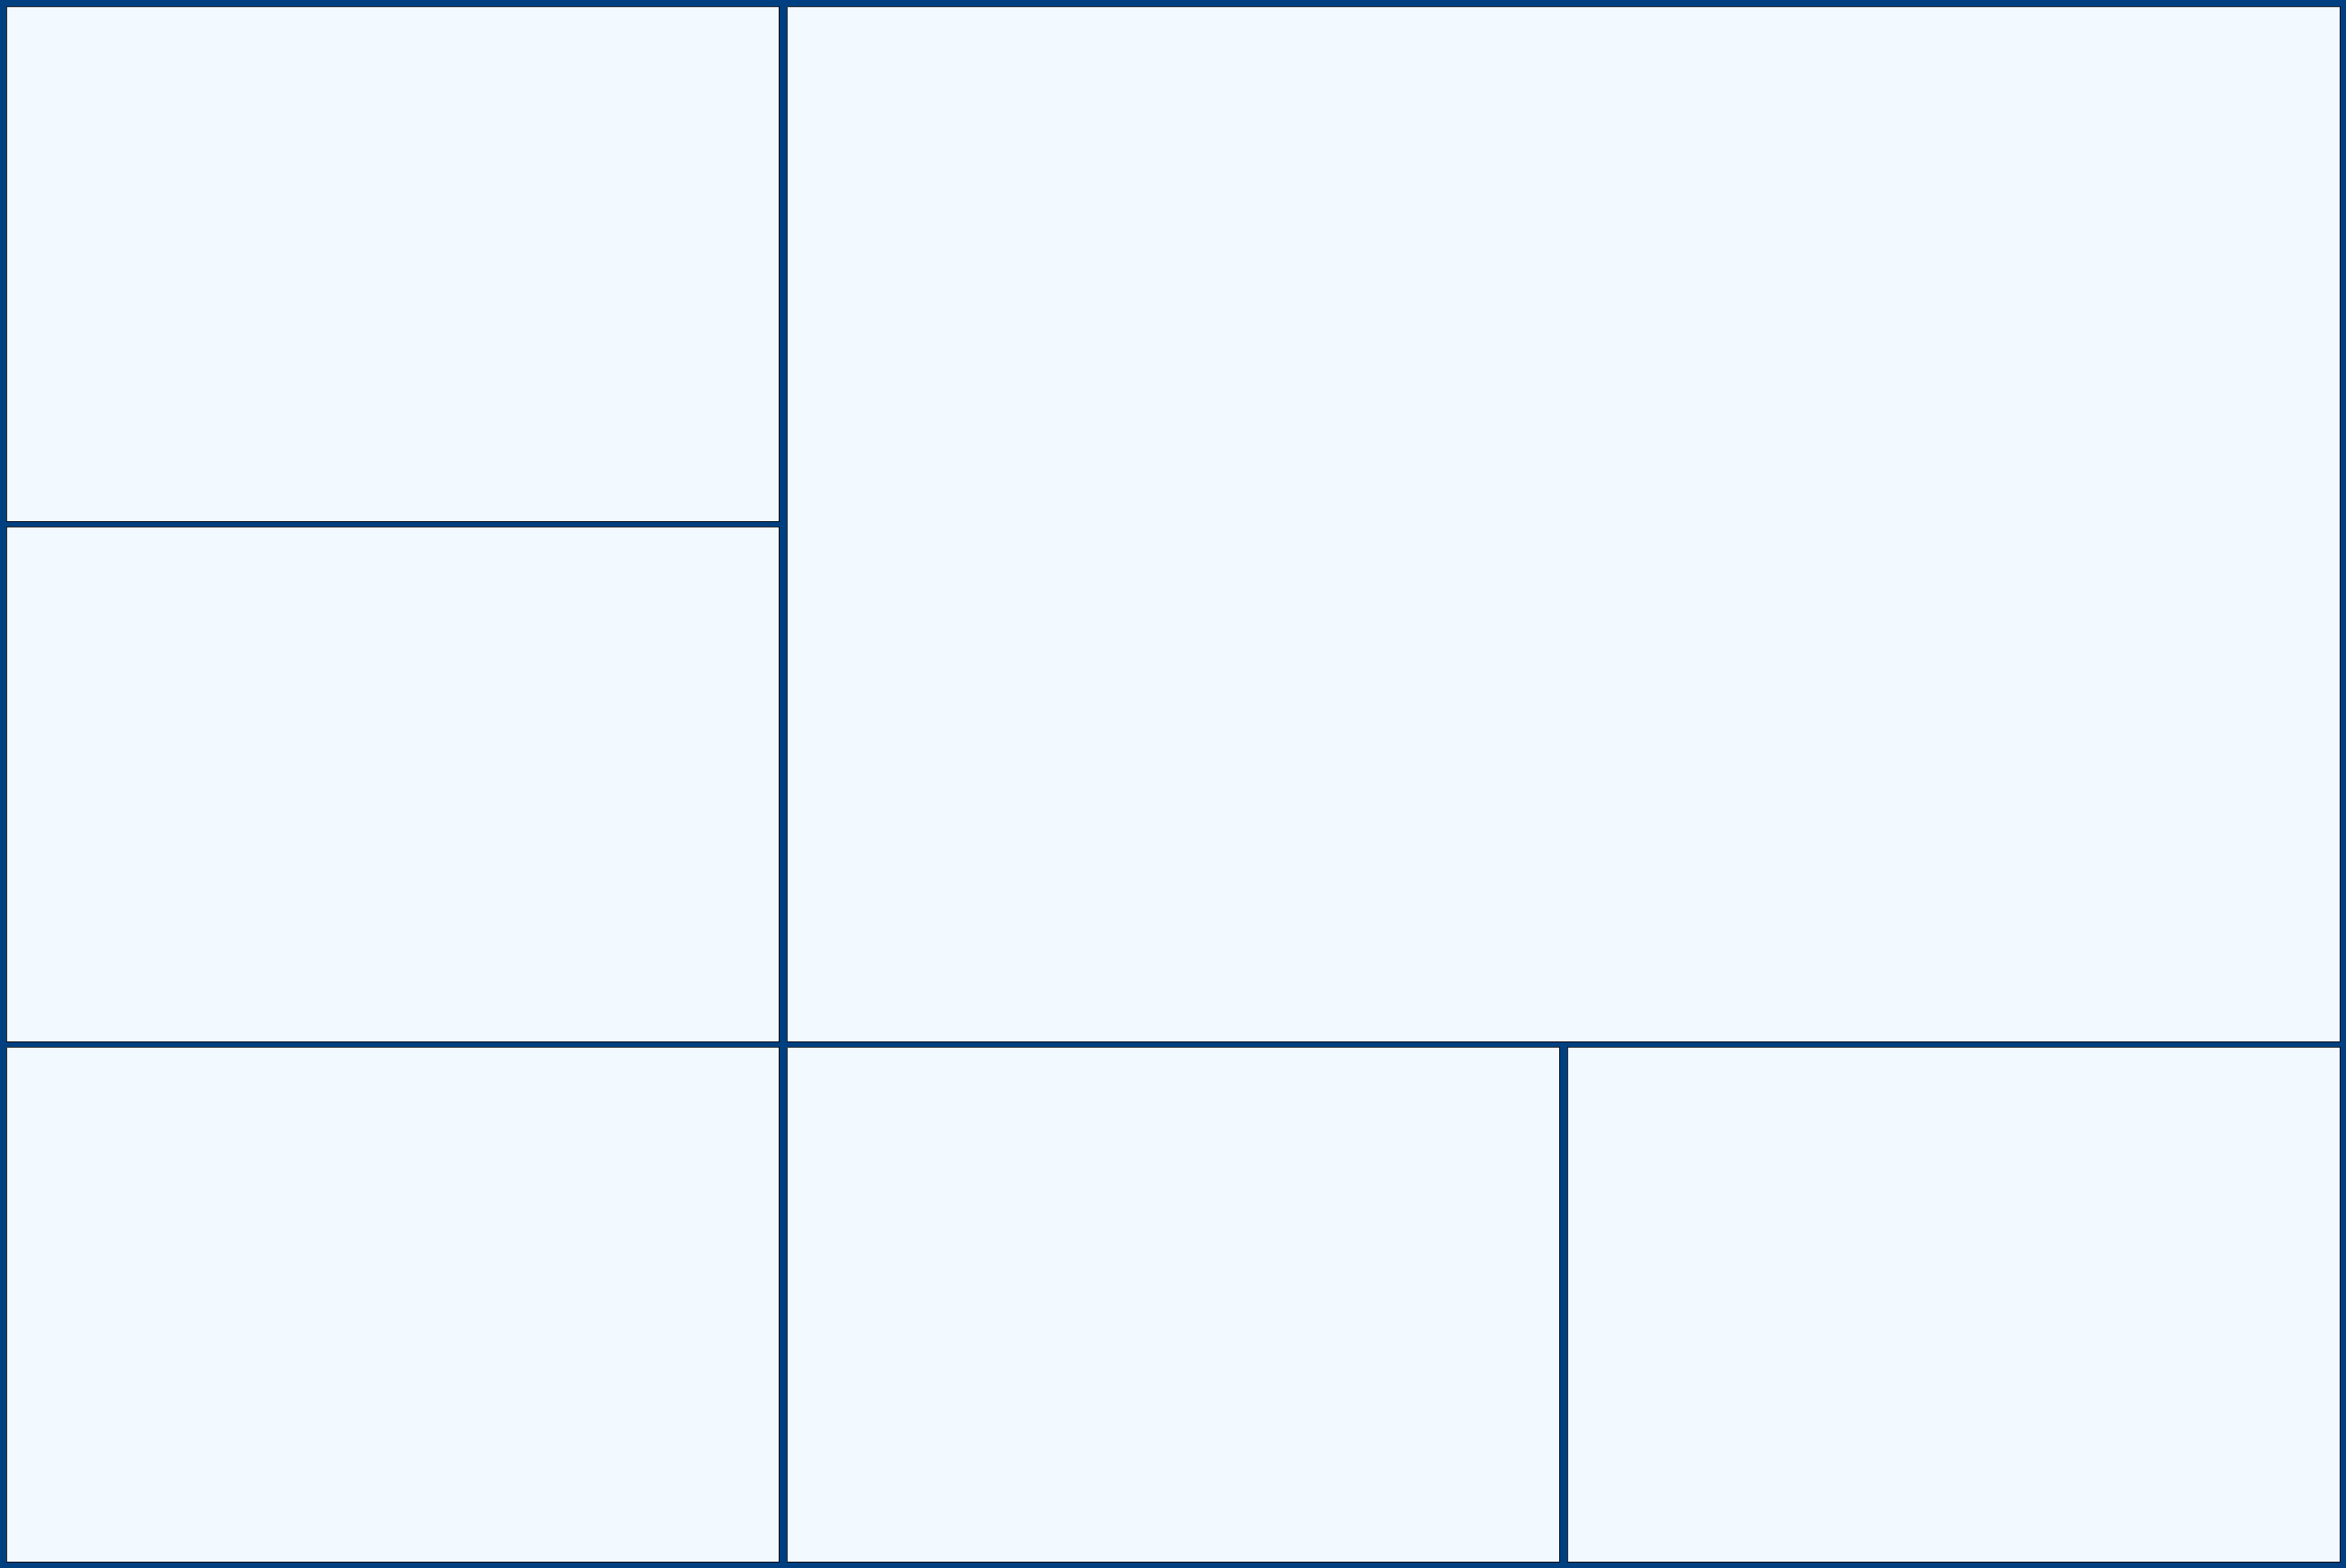

In [10]:
def make_layout():
    
    ## make segmented plotting space
    dash_figure = plt.figure(figsize = (36, 24))
    dash_figure.set_facecolor(set_color['Divider'])
    
    ## define axes
    dash_axis = dict()
    fig_grid = dash_figure.add_gridspec(3, 3, figure = dash_figure,
        hspace = 0.01, wspace = 0.01,
        left= 0, right = 1, bottom = 0, top = 1
        )
    dash_axis['intro'] = dash_figure.add_subplot(fig_grid[0, 0])
    dash_axis['progress'] = dash_figure.add_subplot(fig_grid[1, 0])
    dash_axis['opportunity'] = dash_figure.add_subplot(fig_grid[2, 0],
        projection = set_map['projection'])
    dash_axis['route'] = dash_figure.add_subplot(fig_grid[2, 1],
        projection = set_map['projection'])
    dash_axis['table'] = dash_figure.add_subplot(fig_grid[2, 2])
    dash_axis['travel'] = dash_figure.add_subplot(fig_grid[0:2,1:3],
        projection = set_map['projection'])
    
    ## find map extent
    for i in set_map['panel']:
        dash_axis[i].set_extent(set_map['extent'])
    
    ## remove axis ticks
    for i in dash_axis.keys():
        dash_axis[i].tick_params(
            labelbottom = False, labeltop = False,
            labelleft = False, labelright = False,
            bottom = False, top = False,
            left = False, right = False,
            color = set_color['Coast']
        )
        dash_axis[i].set_facecolor(set_color['Background'])
        
    ## set coordinate system for non-map panels
    for i in ['intro', 'progress', 'table']:
        dash_axis[i].set_xlim(0, 12)
        dash_axis[i].set_ylim(0,  8)
        
    return dash_figure, dash_axis

## save dashboard visualization to disk (run at end)
def save_dashboard(): 
    dash_figure.savefig("C_Output/us_travels.png")
    dash_figure.savefig("C_Output/us_travels.pdf")
    
## execute functions
dash_figure, dash_axis = make_layout()

# Non-Map Panels

### Progress Panel

In [11]:
## tabulate statistics
def tabulate_goal_statistics(dat):
    
    ## unpack data
    dat['Unvisit'] = 1 - dat['Visit']
    dat['Visit'] = dat['Visit'] - dat['Photo']
    key_cats = ['Photo', 'Visit', 'Unvisit']
    
    ## calculate city statistics
    city_stats = dat[key_cats].sum()
    city_stats.name = 'city'
    
    ## calculate state statistics
    dat = dat.loc[dat.IsState, ].groupby('State').max()[key_cats]
    dat['Visit'] = dat['Visit'] * (1 - dat['Photo'])
    dat['Unvisit'] = 1 - (dat['Visit'] + dat['Photo'])
    state_stats = dat.sum()
    state_stats.name = 'state'
    
    ## package and return statistics
    dat = pd.concat([city_stats, state_stats], axis = 1)
    return dat

## render progress bars
def display_progress(prog):
    
    ## useful constants
    bar_start = 2.5
    bar_y     = 2.5 + 0.4
    full_labels = {'state': 'States', 'city':'Metropolitan\nAreas'}
    full_descrip = {'Unvisit': 'Unvisited', 'Visit': 'Visited',
        'Photo': 'Photographed'}

    ## scale statistics
    scale_bar = lambda a: np.cumsum(a / a.sum()) * (12 - bar_start - 0.5)
    prog['city_scale']  = scale_bar(prog['city'])
    prog['state_scale'] = scale_bar(prog['state'])
    
    ## render bars
    for i in prog.columns[0:2]:
        
        ## render bars and bar counts
        bar_label = ''
        for j in prog.index[::-1]:
            if i == prog.columns[1]:
                bar_label = full_descrip[j]
            dash_axis['progress'].barh(
                height = 1, left = bar_start,
                color = set_color[j], edgecolor = set_color['Photo'],
                linewidth = 2, align = 'edge',
                y = bar_y, width = prog.loc[j, i + '_scale'],
                label = bar_label
            )
            dash_axis['progress'].text(
                y = bar_y + 0.20,
                x = prog.loc[j, i + '_scale'] + bar_start - 0.12,
                s = prog.loc[j, i],
                bbox = set_bbox,
                horizontalalignment = 'right',
                size = set_fontsize['M']
            )

        ## label bars
        dash_axis['progress'].text(
            y = bar_y + 0.5, x = bar_start - 0.1,
            s = full_labels[i], size = set_fontsize['M'],
            horizontalalignment = 'right',
            verticalalignment = 'center'
            )

        ## advance height stack
        bar_y += 4.0 - 1 - 1
        
    ## render legend
    dash_axis['progress'].legend(
        loc = 'upper left',
        fontsize = set_fontsize['S'],
        facecolor = set_bbox['fc'],
        edgecolor = set_bbox['ec']
    )

## execute code
goal_stats = tabulate_goal_statistics(city_roster.copy())
display_progress(goal_stats)

### Table Panel

In [12]:
## render planned route information table
def render_table(route):
    
    ## define columns and column display names
    sep = '\n\n'
    route_names = {'route':'Planned\nRoute' + sep,
        'mileage':'Driving\nMiles' + sep,
        'trip_days':'Trip\nDays' + sep,
        'best_temp_1':'Best Weather\nQ1-Q2' + sep,
        'best_temp_2':'\nQ3-Q4' + sep,
        'score':'Goal\nContrib.' + sep,
        'pre_travel':'Pre-Travel\n' + sep,
        'states_etc':'States\n(And Equivalent)' + sep
        }
    
    route_len = {
        'route':18, 'mileage':10, 'trip_days':10 - 2, 'best_temp_1':10,
        'best_temp_2':10, 'score':10, 'pre_travel':10, 'states_etc':26
                }
    route = route.loc[:, route_names.keys()]
    route.columns = route_names.values()
    
    ## convert table to 2D list format
    route_list = []
    for i in route.index:
        route_list.append(list(route.loc[i,]))
        
    ## render table
    access_object = dash_axis['table'].table(
        cellText = route_list,
        rowLabels = None,
        colLabels = route.columns,
        edges = 'open', loc = 'lower right',
        colLoc = 'left', cellLoc = 'left',
        bbox = [0.001, 0.001, 0.94, 0.83],
        colWidths = list(route_len.values())
        )
    access_object.auto_set_font_size(False)
    access_object.set_fontsize(set_fontsize['S'])

render_table(route_roster)

# Common Map Elements

#### Underlying Maps

In [13]:
def render_base_map():
    
    for i in set_map['panel']:
        
        ## outline land masses
        dash_axis[i].add_feature(feature.LAND,
            facecolor = set_color['Land'],
            lw = 1, edgecolor = set_color['Clear'])
        
        ## outline state borders
        dash_axis[i].add_feature(feature.STATES,
            edgecolor = set_color['Border'], lw = 1)
        
        ## outline coastliness
        dash_axis[i].add_feature(feature.COASTLINE,
            edgecolor = set_color['Coast'], lw = 1)
        
        ## outline lakes
        dash_axis[i].add_feature(feature.LAKES,
            edgecolor = set_color['Border'],
            facecolor = set_color['Background'], lw = 1,zorder = 1)

## execute code
render_base_map()

# Map Panels

### Opportunity Panel

In [14]:
## interpolate the level of opportunity nearest to each point near contiguous us
def predict_nearest_opportunity(city = city_roster.copy()):
    
    ## limit analysis to contiguous us and canadian cities
    city = city.loc[~city.State.isin(['AK', 'HI', 'PR']), :]
    
    ## train score model using existing points
    knn_model = KNeighborsRegressor(weights = 'distance').fit(
        city.loc[:, ['lon', 'lat']],
        city.Score.values
        )
    
    ## predict score values for a grid of points
    xlim = (min(city_roster.lon.values), max(city_roster.lon.values))
    ylim = (min(city_roster.lat.values), max(city_roster.lat.values))
    city_grid = np.meshgrid(
        np.arange(min(xlim), max(xlim), 0.5),
        np.arange(min(ylim), max(ylim), 0.5)
        )
    city_grid_pd = np.array(city_grid).reshape(2, -1).T
    city_grid_pd = pd.DataFrame(city_grid_pd)
    city_grid_pd.columns = ['lon', 'lat']
    city_grid.append(knn_model.predict(city_grid_pd))
    city_grid[2] = city_grid[2].reshape(city_grid[0].shape)
    
    return city_grid, knn_model

##  display interpolated opportunity levels
def render_opportunity(int_opp, mask = mex_mask):
    
    ## render opportunity score map
    dash_axis['opportunity'].contourf(
        int_opp[0], int_opp[1], int_opp[2],
        levels = [0, 0.1, 0.5, 1, 1.5, 1.9, 2.01], colors = set_opp_color,
        transform = PlateCarree())
    
    ## mask scoring of water and mexico
    dash_axis['opportunity'].add_feature(feature.LAKES,
        edgecolor = set_color['Border'],
        facecolor = set_color['Background'], lw = 1)
    dash_axis['opportunity'].add_feature(feature.OCEAN,
        edgecolor = set_color['Coast'], zorder = 1,
        facecolor = set_color['Background'], lw = 1)
    dash_axis['opportunity'].add_feature(mask,
        edgecolor = set_color['Coast'], zorder = 1,
        facecolor = set_color['Land'], lw = 1)
    

## execute code
nearest_opportunity, opportunity_model = predict_nearest_opportunity()
render_opportunity(nearest_opportunity)

### Line Panels

In [15]:
## add travel route lines to relevant panels
def display_map_line(map_l):
    for i in map_l.keys():
        for j in map_l[i].keys():
            dash_axis[i].add_geometries(
                map_l[i][j].geoms,
                crs = PlateCarree(),
                edgecolor = set_color['Photo'],
                facecolor = set_color['Clear'],
                linewidth = 2
                )
            
## function to add a set of points to a map panel
def display_map_point(panel_name, f_color, e_color, size,
        city_bool = True, city_xy = city_roster):
    
    if isinstance(city_bool, bool):
        city_bool = [True for i in city_xy.index]
    
    dash_axis[panel_name].scatter(
        city_xy.loc[city_bool, 'lon'].values,
        city_xy.loc[city_bool, 'lat'].values,
        facecolor = f_color, edgecolor = e_color,
        linewidths = 2, s = size,
        transform = PlateCarree())

## packaging function for all map points
def display_all_map_points():
    
    ## render base layer of metro areas points on each map panel
    display_map_point(panel_name = 'route', f_color = set_color['Photo'],
        e_color = set_color['Land'], size = int(2**5.5))
    display_map_point(panel_name = 'opportunity', f_color = set_color['Photo'],
        e_color = set_color['Land'], size = int(2**5.5))
    display_map_point(panel_name = 'travel', f_color = set_color['Land'],
        e_color = set_color['Photo'], size = int(2**7.5))
    
    ## Notate visited / photographed metro areas 
    for i in ['Visit', 'Photo']:
        display_map_point(panel_name = 'travel', f_color = set_color[i],
            e_color = set_color['Photo'], size = int(2**7.5),
            city_bool = city_roster[i].astype(bool))
    
## Execute code
display_map_line({'route': route_kml, 'travel': travel_kml})
display_all_map_points()

# Text Elements

### Statistics

In [16]:
## intro panel
imported_docx['intro'] = imported_docx['intro'].format(
    miles_traveled, # miles traveled
    goal_stats.city.sum(), # Total metro areas on list
    '\n\n') # optional paragraph break

## travel panels
imported_docx['travel'] = imported_docx['travel'].format(
    goal_stats.state[['Photo', 'Visit']].sum(), # states visited
    goal_stats.city[['Photo', 'Visit']].sum(), # cities visited
    int(((1 - (goal_stats.city['Unvisit'] / goal_stats.city.sum())) * 100))
    )

## route panel
imported_docx['route'] = imported_docx['route'].format(
    sum(~route_roster.states_etc.isin(['HI', 'PR', 'AK'])))

### Titles

In [17]:
dash_axis[i]

def render_title(title):
    for i in dash_axis.keys():
        
        ## calculate space between title and edge of panel
        xNpct = (dash_axis[i].get_xlim()[1] - dash_axis[i].get_xlim()[0]) * 0.02
        yNpct = (dash_axis[i].get_ylim()[1] - dash_axis[i].get_ylim()[0]) * 0.03
        
        ## use bbox for map panels
        if i in set_map['panel']:i_bbox = set_bbox
        else:i_bbox = no_bbox
        
        ## render title text  
        dash_axis[i].text(
            x = dash_axis[i].get_xlim()[1] - xNpct,
            y = dash_axis[i].get_ylim()[1] - yNpct,
            s = title[i],
            size = set_fontsize['L'],
            horizontalalignment = 'right',
            verticalalignment   = 'top',
            bbox = i_bbox
        )

title_list = {
    'intro':      'My Travels in the US and Canada',
    'progress':   'Progress Toward Goal',
    'opportunity':'Opportunity For Goal Progress',
    'route':      'Map of Planned Routes',
    'table':      'Planned Route Information',
    'travel':     'My Travels So Far'
}
        
render_title(title_list)

### Captions

In [18]:
## render captions
def render_captions(caption = imported_docx):
    for i in imported_docx.keys():
        
        ## use bbox for map panels
        if i in set_map['panel']:i_bbox = set_bbox
        else:i_bbox = no_bbox
        
        ## calculate position of caption (slightly offset from panel edge)
        x = dash_axis[i].get_xlim()
        y = dash_axis[i].get_ylim()
        
        ## render captions
        dash_axis[i].text(
            x = min(x) + max(x) * 0.03,
            y = min(y) + max(y) * 0.03,
            s = caption[i],
            size = set_fontsize['M'],
            horizontalalignment = 'left',
            verticalalignment   = 'bottom',
            bbox = i_bbox
            )

render_captions()

# Testing

### Test 1: check route_kml and route_roster for consistency

In [19]:
def test_route_consistency(kml = route_kml, roster = route_roster,
        city = city_roster):
    
    ## shape roster and city list
    roster = roster.set_index('route')
    roster = roster.loc[~roster.states_etc.isin(['AK', 'HI', 'PR']), ]
    roster['len'] = np.nan
    city = city.loc[~city.State.isin(['AK', 'HI', 'PR']), ]
    
    ## do the kml and roster files have matching routes?
    t_roster = set(roster.index)
    t_kml = set(kml.keys())
    assert t_roster == t_kml, 'Routes in _kml and _roster files do not match'
    
    ## Do route_roster mileage and route_kml len correlate?
    for i in roster.index:
        roster.loc[i, 'len'] = kml[i].length
    t_corr = np.corrcoef(roster['drive_mileage'].values, roster['len'].values)
    assert t_corr[0, 1] > 0.9, 'Route mileage and kml length do not correlate'

test_route_consistency()

### Test 2: check _kml objects against city_roster for proximity

In [20]:
## are the travel/route lines and metro areas proximate - test engine
def test_kml_roster_proximity(kml, city = city_roster):
    
    ## create container to hold distances
    city = city.set_index('City')
    city = city.loc[~city.State.isin(['AK', 'HI', 'PR']), ]
    city_kml_dist = np.zeros((len(city.index), len(kml.keys())))
    city_kml_dist = pd.DataFrame(city_kml_dist)
    city_kml_dist.index = city.index
    city_kml_dist.columns = kml.keys()
    
    ## calculate distances
    for i in city_kml_dist.index:
        for j in city_kml_dist.columns:
            k = MultiPoint([(city.at[i, 'lon'], city.at[i, 'lat'])])
            city_kml_dist.at[i, j] = np.round(k.distance(kml[j]), 2)
    
    ## confirm all cities are proximate to kml and vis versa
    min_kml  = city_kml_dist.min()
    min_city = city_kml_dist.T.min()
    assert min_kml.max() < 0.2, 'Some KML lines are too far from metro areas'
    assert min_city.max() < 0.2, 'Some metro areas are too far from kml lines'
    
## test package function
def test_proximity(route = route_kml, travel = travel_kml, metro = city_roster):
    ## are planned routes near metro areas and vis versa?
    test_kml_roster_proximity(route, metro)
    ## are visited metro areas near travels and vis versa?
    test_kml_roster_proximity(travel, metro.loc[metro.Visit.astype(bool), ])

test_proximity()

### Test 3: Confirm that opportunity shading matches city_roster scores

In [21]:
def test_opportunity(mod = opportunity_model, city = city_roster.copy()):
    city = city.loc[~city.State.isin(['AK', 'HI', 'PR']), :]
    mod_predict = mod.predict(city[['lon', 'lat']])
    resid = city['Score'] - mod_predict
    mae = np.round(sum(abs(resid)) / len(resid), 2)
    assert mae < 0.5, 'Opportunity score map does not match original scores'

test_opportunity()

### Test 4: Confirm that all 50 states are represented in all places

In [22]:
## check state counts in goal_stats, city_roster, route_roster
def test_50_states(goal = goal_stats, city = city_roster, route = route_roster):
    
    ## do the goal statistics on states add to 50?
    assert sum(goal.state) == 50, 'Goal statistics for states do not equal 50'
    
    ## do city_roster states add up to 53 (50 states  + CAN, PR, DC)
    msg = 'City roster states do not equal 50 + CAN, PR, DC'
    assert len(set(city_roster.State)) == 53, msg
    
    ## do route_roster states add up to 53 (50 states  + CAN, PR, DC)
    msg = 'Route roster states do not equal 50 + CAN, PR, DC'
    ne_states = 'ME, VT, NH, MA, CT, RI, NY, NJ, PA'
    route_states = ', '.join(route.states_etc).replace('Northeast + ', '{0}, ')
    route_states = set(route_states.format(ne_states).split(', '))
    assert len(route_states) == 53, msg

test_50_states()

# Final Tasks

### Render Visualizations

In [23]:
save_dashboard()

### Misc

In [24]:
time_check('[End]')


 Time Check [End]: 11:29:30 

